In [2]:
import time
import gym
import matplotlib.pyplot as plt

In [ ]:
!pip install -e gymsnake 

In [5]:
env = gym.make("snake:Snake-v0")

pygame 2.1.0 (SDL 2.0.16, Python 3.7.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


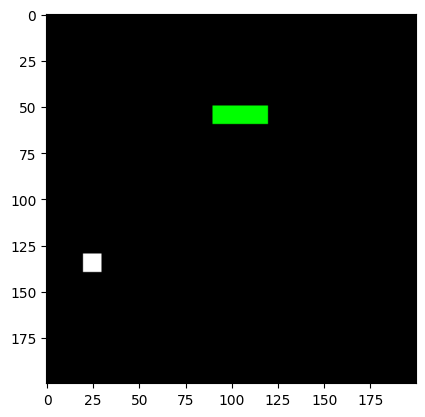

In [6]:
env.reset()
env.render("human")
action = env.action_space.sample()
obs, reward, done, info = env.step(action)
plt.figure()
plt.imshow(obs)
plt.show()

In [33]:
import numpy as np

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Activation, Flatten, 
                                     Convolution2D, Permute)
from tensorflow.keras.optimizers import Adam

# Keras-RL
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import ModelIntervalCheckpoint

In [11]:
env = gym.make("snake:Snake-v0")
nb_actions = env.action_space.n
nb_actions

4

In [12]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 4

In [13]:
class ImageProcessor(Processor):
    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = img.resize(IMG_SHAPE)
        # img to grayscale
        img = img.convert("L")
        img = np.array(img)
        return img.astype("uint8")
    
    def process_state_batch(self, batch):
        processed_batch = batch.astype("float32") / 255.0
        return processed_batch
    
    def process_reward(self, reward):
        return np.clip(reward, -1.0, 1.0)

## Model Creation

Depending on your type of problem, read papers with similar problems, to find a good proven solution, in case your is not satisfatory enough

In [14]:
input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])
input_shape

(4, 84, 84)

In [19]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))

model.add(Convolution2D(32, (8, 8), strides=(4, 4), 
                        kernel_initializer="he_normal"))
model.add(Activation("relu"))
model.add(Convolution2D(64, (4, 4), strides=(2, 2), 
                        kernel_initializer="he_normal"))
model.add(Activation("relu"))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), 
                        kernel_initializer="he_normal"))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(nb_actions))
model.add(Activation("linear"))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_1 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_______________________________________

In [20]:
memory = SequentialMemory(limit=1_000_000, window_length=WINDOW_LENGTH)

In [21]:
processor = ImageProcessor()

In [22]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr="eps",
                              value_min=0.1,
                              value_max=1.0,
                              value_test=0.05,
                              nb_steps=1_000_000)

In [25]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor, nb_steps_warmup=50_000,
               gamma=0.99, target_model_update=100_000,
               train_interval=4, delta_clip=1)

In [27]:
dqn.compile(Adam(learning_rate=0.00025), metrics=["mae"])

In [29]:
weights_filename = "test_dqn_snake_weights.h5f"
checkpoint_weights_filename = "test_dqn_snake_weights_{step}.h5f"
checkpoint_callback = ModelIntervalCheckpoint(checkpoint_weights_filename, 
                                              interval=100_000, verbose=1)

In [ ]:
dqn.fit(env, nb_steps=1_500_000, 
        callbacks=[checkpoint_callback],
        log_interval=100_000,
        visualize=False)
dqn.save_weights(weights_filename, overwrite=True)

Training for 1500000 steps ...
Interval 1 (0 steps performed)
 67909/100000 [===================>..........] - ETA: 10:46 - reward: -0.0212

In [ ]:
# Load the weights
model.load_weights("test_dqn_snake_weights.h5f")
memory = SequentialMemory(limit=1_000_000, window_length=WINDOW_LENGTH)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr="eps",
                              value_min=0.1,
                              value_max=0.2,
                              value_test=0.05
                              nb_steps=100_000)
processor = ImageProcessor()
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor, nb_steps_warmup=50_000,
               gamma=0.99, target_model_update=10_000)
dqn.compile(Adam(learning_rate=0.00025), metrics=["mae"])

In [ ]:
# sleep is 0.2, so the user can see the agent playing
env.sleep = 0.2
dqn.test(env, nb_episodes=1, visualize=True)